<img src="https://pages.cnpem.br/workshopbioimagens/wp-content/uploads/sites/166/2023/06/logo-ilum-2048x382.png" alt="Descrição da imagem" style="width: 1000px; height: auto; ">


<div style=" padding: 10px; font-size: 38px; text-align: center;">
<strong> Stop right now, thank you very much 🤚💃:</strong> 
<div style=" padding: 10px; font-size: 33.2px; text-align: center;">
<strong>Implementação da  estratégia de Parada Antecipada</strong> 

<div style=" padding: 10px; font-size: 17px; text-align: center;">
<strong>Autores:</strong> Lorena Ribeiro Nascimento & Maria Emily Nayla Gomes da Silva
<div style=" padding: 10px; font-size: 17px; text-align: center;">
<strong>Professor:</strong> Daniel R. Cassar

<div style="background-color: lightblue; font-size: 18px; padding: 10px;">
<div style="text-align: justify"><strong>Objetivo:</strong> Implemente uma estratégia de Parada Antecipada (<em>Early Stopping</em>) no processo de treino da rede neural feita em Python puro ou no processo de treino da rede neural feita em <em>PyTorch</em></div>

## 📝 **Introdução**  

<p align = 'justify'> 
Nesse Notebook implementaremos a técnica de Parada Antecipada (Early Stopping) no treinamento de uma rede neural implementada em PyTorch. O uso da parada antecipada consiste em separar parte dos dados para validação, além de treino e teste, e avaliar o desempenho dela ao longo das épocas de treinamento. Essa avaliação é utilizada para buscar encontrar um momento em que o desempenho atinge uma estabilidade, analisada por valores de delta mínimo e paciência. O primeiro monitora se o modelo está melhorando ou se mantendo estável pelo valor de variação que está tendo entre as perdas de diferentes épocas, já o segundo é a quantidade de vezes que vai esperar, quando essa variação mínima for atingida, para parar, caso volte a variar mais. A partir desses fatores busca encontrar um ponto de estabilidade e interrompe o treinamento.</p>

 <p align = 'justify'> 
Essa é uma técnica em Reforço de Gradiente que permite encontrar um número de iterações mais próximo do ideal para generalizar os dados sem overfittar neles. Desse modo, reduzindo a quantidade épocas necessárias, consequentemente diminuindo também o custo computacional, e o overfitting.</p> 

<p align = 'justify'> 
Além disso, para a construção dessa rede será utilizado uma estrutura de CNN (Rede Neural Convolucional) para o Dataset MNIST que possui imagens de números manuscritos, e é um banco de dados amplamente utilizado para construções e testes de redes convolucionais. Para a impementação da rede baseou-se nas referências 2 e 3 deste Notebook.</p>

## 📚 **Importação das Bibliotecas e Dataset** 

In [1]:
#Importando a biblioteca torch para treinar a CNN
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#Para gerar o gráfico com os dados do dataset MNIST
import matplotlib.pyplot as plt

#Para criar a pasta "results", as quais guardam os resoultados de loss de treino e validação
import os

import numpy as np

## 🏋🏻‍♀️ **Treinamendo a CNN com Parada Antecipada**  

### 🎲 *Separando os dados em treino, validação e teste*

A primeira etapa para treinar nosso modelo foi definir algumas variáveis. Definimos o número de épocas que gostaríamos de treinar o modelo, assim como o tamanho de lote de treino e teste, ou seja, quantos dados há em cada um de seus respectivos lotes. Dos dados totais de treino, definimos que gostaríamos de $80\%$ para treino e  $20\%$ para validação. A taxa de aprendizado foi de  $0.01$ e, para a descida do gradiente, definimos um momento de $0.5$. 

In [2]:
NUM_EPOCAS = 25
TAMANHO_LOTE_TREINO = 64
TAMANHO_LOTE_TESTE = 1000
TAMANHO_TESTE = 0.8
TAMANHO_VALIDACAO = 0.2
TAXA_APRENDIZADO = 0.01
INTERVALO_LOG = 10
MOMENTO = 0.5

SEMENTE = 1420

In [3]:
transform = transforms.ToTensor()
dataset_MNIST = datasets.MNIST(root='data', train=True, download=True, transform=transform)

TAMANHO_TREINO = int(0.8 * len(dataset_MNIST))
TAMANHO_VALIDACAO = len(dataset_MNIST) - TAMANHO_TREINO
dados_treino, dados_validacao = random_split( dataset_MNIST, [TAMANHO_TREINO, TAMANHO_VALIDACAO])

treino_loader = DataLoader(dados_treino, batch_size= TAMANHO_LOTE_TREINO, shuffle=True)
validacao_loader = DataLoader(dados_validacao, batch_size=TAMANHO_LOTE_TREINO, shuffle=False)

dados_teste = datasets.MNIST(root='data', train=False, download=True, transform=transform)
teste_loader = DataLoader(dados_teste, batch_size=TAMANHO_LOTE_TESTE, shuffle=False)


QUANTIDADE_LOTES = len(treino_loader)

### 🌆 *Arquitetura do modelo*


Para a arquitetura da CNN, estabelecemos duas camadas convolucionais, aplicando a função de ativação ReLu - zera os gradientes negativos - e duas camadas de pooling - redução de dimensionalidade - entre elas. Além disso, foi utilizada duas camada totalmente conectadas com funções lineares, e para a parada antecipada os valores de delta mínimo e paciência, sendo **0,0001**  e **3**, respectivamente. A escolha do delta se deu pelo conhecimento prévio do modelo convolucional com MNIST, em que se conhecia a existência de variações pequenas.

In [4]:
class Rede(nn.Module):
    def __init__(self):
        super(Rede, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
DELTA_MINIMO = 0.0001 
PACIENCIA = 3

### 🛑 *Definindo a função da Parada Antecipada*

Então, foi definida uma classe para aplicar a técnica de parada antecipada, nessa é comparada os valores das perdas das validações e caso sejam menores que a menor perda encontrada são comparadas a partir do delta mínimo e da paciência.

In [6]:
class EarlyStopper:
    def __init__(self, PACIENCIA, DELTA_MINIMO):
        self.patience = PACIENCIA
        self.min_delta = DELTA_MINIMO
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, perda_validacao):
        if perda_validacao < self.min_validation_loss:
            self.min_validation_loss = perda_validacao
            self.counter = 0
        elif perda_validacao >= (self.min_validation_loss + self.min_delta): 
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### 👩‍💻 **Treinando a rede com Parada Antecipada 🤚**

Para realizar o treinamento da rede foi, por fim, instanciada a rede, definido seu otimizador (Descida do Gradiente Estocastico) e seu critério de perda (CrossEntropy).

In [7]:
rede_parada = Rede()
otimizador = optim.SGD(rede_parada.parameters(), lr=TAXA_APRENDIZADO, momentum=MOMENTO)   #Descida do Gradiente Estocastico
criterio_perda = nn.CrossEntropyLoss()

perdas_treino_parada = []
perdas_teste_parada = []
perdas_validacao_parada = []

Definindo a função de treino:

In [8]:
os.makedirs('results_comparadaantecipada', exist_ok=True)

def treino(epoca):   
    running_loss = 0.
    ultima_perda = 0.

    for lote_idx, dado in enumerate(treino_loader):

        inputs, targets = dado

        otimizador.zero_grad()

        output = rede_parada(inputs)

        loss = criterio_perda(output, targets)

        loss.backward()

        otimizador.step()

        running_loss += loss.item()

    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoca, lote_idx * len(dado), len(treino_loader.dataset),
        100. * lote_idx / len(treino_loader), loss.item()))

    if lote_idx % QUANTIDADE_LOTES == QUANTIDADE_LOTES - 1:      
        ultima_perda = running_loss / len(treino_loader.dataset) # loss per batch
        print('  lote {} loss: {}'.format(lote_idx + 1, ultima_perda))
        running_loss = 0.
    
    return ultima_perda

Executando o treinamento da rede pelo número de épocas determinado implementando a parada antecipada.

In [9]:
parada_antecipada = EarlyStopper(PACIENCIA, DELTA_MINIMO)

for epoca in range(1, NUM_EPOCAS + 1):
    rede_parada.train(True)
    perdas_treino_parada.append(treino(epoca))

    rede_parada.eval()
    perda_validacao_parada = 0
    correto = 0
    total = 0

    with torch.no_grad():
        for dado, target in validacao_loader:
            output = rede_parada(dado)
            perda_lote = criterio_perda(output, target).item()
            perda_validacao_parada += perda_lote * dado.size(0)  # Desfaz a média para cada lote
            pred = output.data.max(1, keepdim=True)[1]
            correto += pred.eq(target.data.view_as(pred)).sum().item()
            total += dado.size(0)

    perda_validacao_parada /= total
    perdas_validacao_parada.append(np.round(perda_validacao_parada, 3))
    if parada_antecipada.early_stop(perda_validacao_parada):             
        break

Train Epoch: 1 [1498/48000 (100%)]	Loss: 0.314171
  lote 750 loss: 0.017827209513013562
Train Epoch: 2 [1498/48000 (100%)]	Loss: 0.108515
  lote 750 loss: 0.0033830881516138714
Train Epoch: 3 [1498/48000 (100%)]	Loss: 0.139172
  lote 750 loss: 0.002224190976470709
Train Epoch: 4 [1498/48000 (100%)]	Loss: 0.127563
  lote 750 loss: 0.0017421618746011518
Train Epoch: 5 [1498/48000 (100%)]	Loss: 0.067721
  lote 750 loss: 0.0014891152829610897
Train Epoch: 6 [1498/48000 (100%)]	Loss: 0.067909
  lote 750 loss: 0.0012938691909075714
Train Epoch: 7 [1498/48000 (100%)]	Loss: 0.048348
  lote 750 loss: 0.0011674620215198956
Train Epoch: 8 [1498/48000 (100%)]	Loss: 0.112655
  lote 750 loss: 0.0010572379408598257
Train Epoch: 9 [1498/48000 (100%)]	Loss: 0.021766
  lote 750 loss: 0.0009769420950372781
Train Epoch: 10 [1498/48000 (100%)]	Loss: 0.040383
  lote 750 loss: 0.0008931688353040954
Train Epoch: 11 [1498/48000 (100%)]	Loss: 0.021641
  lote 750 loss: 0.0008449292642180808
Train Epoch: 12 [1498

### 📈*Gráfico da curva de aprendizado com Parada Antecipada*

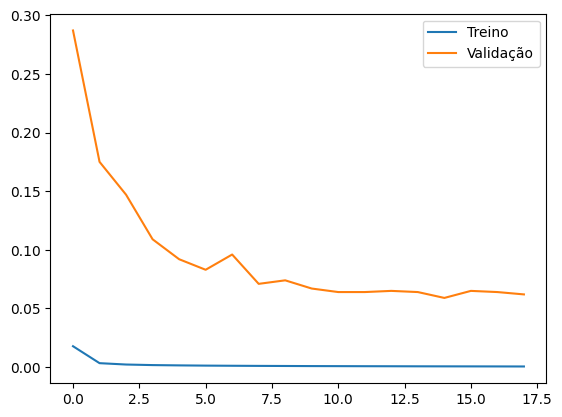

In [10]:
plt.plot(list(range(len(perdas_treino_parada))), perdas_treino_parada, label = "Treino")
plt.plot(list(range(len(perdas_validacao_parada))), perdas_validacao_parada, label = "Validação")
plt.legend()

A rede foi treinada por 25 épocas, mas como observado pelo gráfico houve a parada antecipada na época 23, vale ressaltar também que é possível observar que as variações foram bem pequenas, dentre as duas primeiras casas decimais. Além disso a curva de treino atingiu um plato maior e antes do número de época da validação, em que a segunda variou mais que o primeiro, mas em intervalos pequenos.

### ✅ *Teste do modelo com Parada Antecipada*

In [11]:
def teste():
    rede_parada.eval()
    perda_teste = 0
    correto = 0
    total = 0

    with torch.no_grad():
        for dado, target in teste_loader:
            output = rede_parada(dado)
            perda_lote = criterio_perda(output, target).item()
            perda_teste += perda_lote * dado.size(0)  # Desfaz a média para cada lote
            pred = output.data.max(1, keepdim=True)[1]
            correto += pred.eq(target.data.view_as(pred)).sum().item()
            total += dado.size(0)

    perda_teste /= total
    perdas_teste_parada.append(perda_teste)

    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        perda_teste, correto, total, 100. * correto / total))
    

In [12]:
teste()


Test set: Avg. loss: 0.0464, Accuracy: 9846/10000 (98%)



Observa-se uma acurácia de 99% o que é um ótimo resultado, e atende também a expectativa, visto que foi utilizado um Dataset que tem diversos estudos relacionados que mostram bons treinamentos com valores de acurácia semelhantes ao encontrado.

## 😁 **Conclusão** 

<p align = 'justify'>
Portanto, foi possível aplicar a técnica de parada antecipada, obtendo uma parada duas épocas antes do delimitado(25), e obtendo uma acurácia de 99% do modelo. Além disso, conclui-se que essa técnica é um método eficiente para generalização do modelo, evitando overfitting, por meio da comparação das perdas dos dados de validação. Além disso, observou-se que a definição do delta mínimo pode variar dependendo da rede, visto que, como no nosso problema a variação era muito pequeno, sendo assim foi necessário um valor beixo. Todavia, outros problemas poderiam funcionar melhor com um delta mínimo maior, assim, é sempre importante analisar e compreender o comportaento da sua rede. Por fim, a parada antecipada é uma técnica de implementação simples que funciona bem para evitar o sobreajuste dos modelos, principalmente em modelos de aprendizado profundo. </p>

## 🗃️  **Referências!** 

 [1] Team, Keras. Keras Documentation: EarlyStopping. https://keras.io/api/callbacks/early_stopping/. Acesso em 29 de maio de 2025.
 
 [2] Koehler, G. (2020). MNIST Handwritten Digit Recognition in PyTorch. Nextjournal. Disponível em: https://nextjournal.com/gkoehler/pytorch-mnist

 [3] PASZKE, Adam et al. *Training a classifier*. PyTorch Tutorials, 2024. Disponível em: <https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html>. 

 [4] PUGA, Juan. Early stopping in PyTorch. Stack Overflow, 04 abr. 2022. Disponível em: https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch.
